# Import libraries and data pre-processing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import scipy
import datetime
import seaborn as sn
from collections import Counter
import re
from itertools import chain, islice
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

In [2]:
dat= pd.read_csv('data/TopCharts_complete.csv')

In [3]:
print(dat.dtypes) # type of each feature

rank                  int64
date                 object
artist               object
title                object
streams              object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
uri                  object
duration_ms         float64
time_signature      float64
dtype: object


In [4]:
# we see problem with 'streams' feature being a string due to the commas present in the numbers
dat_copy = dat.copy()
dat_copy.streams = dat_copy.streams.str.replace(',', '') # remove commas
dat_copy.streams = dat_copy.streams.astype(int) # convert to int
dat.loc[:,'streams'] = dat_copy['streams']
print(dat.streams.head())

0    1371493
1    1180074
2    1064351
3    1010492
4     874289
Name: streams, dtype: int32


# Artists

### Comparing the probability of an artist having another number one song (after having one already) to the probability of an artist having a number one song

In [5]:
print('Number of different artists with a #1 song:', len(dat.artist[dat['rank']==1].unique()))
print('Total number of artists included in dataset:', len(dat.artist.unique()))
print('\nProportion of artists in dataset with a #1 song:', len(dat.artist[dat['rank']==1].unique())/len(dat.artist.unique()))

Number of different artists with a #1 song: 40
Total number of artists included in dataset: 813

Proportion of artists in dataset with a #1 song: 0.04920049200492005


* Wow, very few artists -- only around five percent -- have a number one song! This is not too surprising, however, since it feels like the same artists seem to appear over and over in the number one song position (e.g., Drake, Post Malone, etc.). Keep in mind that this dataset only includes songs and artists that reach the top 200 -- I can only imagine how small the proportion of __ALL__ artists that reach the number one song position must be.

* Now, let's examine the breakdown of number one songs by artist:

In [6]:
num_one_artists = dat['artist'].groupby(dat.title[dat['rank']==1]).unique().apply(pd.Series)[0]
print('Artists with #1 songs:', num_one_artists.unique())

Artists with #1 songs: ['Taylor Swift' 'Logic' 'Ariana Grande' 'Harry Styles' 'Mariah Carey'
 'Kanye West' 'DaBaby' 'Lil Uzi Vert' 'Migos' '21 Savage' 'Post Malone'
 'The Weeknd' 'Luis Fonsi' 'Lil Baby' 'Tyler, The Creator' 'Lil Peep'
 'Drake' 'Travis Scott' 'Kendrick Lamar' 'Ed Sheeran' 'J. Cole'
 'Selena Gomez' 'Juice WRLD' 'Eminem' 'Sheck Wes' 'Lil Wayne' 'Lil Nas X'
 'Arizona Zervas' 'Lil Tecca' 'XXXTENTACION' 'Shawn Mendes'
 'Jonas Brothers' 'Roddy Ricch' 'Young Thug' 'Childish Gambino' 'NAV'
 'French Montana' 'DJ Khaled' 'Kodak Black' 'Billie Eilish']


In [7]:
num_one_artists_freq_dict = dict(zip(Counter(num_one_artists).keys(), Counter(num_one_artists).values()))
print('Number of different number one songs by artist:', num_one_artists_freq_dict)

Number of different number one songs by artist: {'Taylor Swift': 5, 'Logic': 2, 'Ariana Grande': 4, 'Harry Styles': 1, 'Mariah Carey': 1, 'Kanye West': 3, 'DaBaby': 1, 'Lil Uzi Vert': 5, 'Migos': 1, '21 Savage': 1, 'Post Malone': 8, 'The Weeknd': 3, 'Luis Fonsi': 2, 'Lil Baby': 2, 'Tyler, The Creator': 1, 'Lil Peep': 1, 'Drake': 7, 'Travis Scott': 3, 'Kendrick Lamar': 1, 'Ed Sheeran': 2, 'J. Cole': 2, 'Selena Gomez': 1, 'Juice WRLD': 1, 'Eminem': 1, 'Sheck Wes': 1, 'Lil Wayne': 1, 'Lil Nas X': 3, 'Arizona Zervas': 1, 'Lil Tecca': 1, 'XXXTENTACION': 2, 'Shawn Mendes': 1, 'Jonas Brothers': 1, 'Roddy Ricch': 1, 'Young Thug': 1, 'Childish Gambino': 1, 'NAV': 1, 'French Montana': 1, 'DJ Khaled': 1, 'Kodak Black': 1, 'Billie Eilish': 2}


* We observe that only some of the biggest names in music have a number one song. It appears that artists with more than one number one song are in an even more exclusive group, as we can see that very few artists have more than one number one hit.

* So, if an artist has a number one song, just how many do they have?

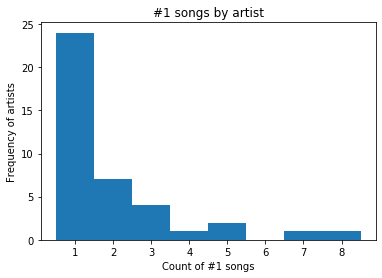

In [8]:
num_one_songs_by_art = [x for x in Counter(num_one_artists).values()]
plt.hist(num_one_songs_by_art, bins = np.arange(0.5,9,1)) # better align our bins
plt.title('#1 songs by artist')
plt.xlabel('Count of #1 songs')
plt.ylabel('Frequency of artists')
plt.show()

* We confirm that the number of artists with a particular count of number one songs decreases significantly for each additional number one song.


* So, we now model the probability of an artist having a number one song after having one already -- let's try using the Geometric model supported on the set {1, 2, 3, ...} (since there is no clear maximum to the number of number one songs artists can have) with different parameters and maximize the log-likelihood.

The log-likelihoods for each of the Geometric models are listed as follows: [-96.21246383041704, -73.0801149986182, -62.06923498664801, -56.573828601839836, -54.75862726423568, -56.168363493731675, -61.2219371262608, -71.6938206374983, -94.01523925308085].


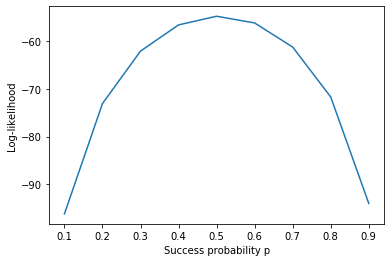

In [9]:
### Geometric model

data = num_one_songs_by_art
p_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n = len(data)

def log_likelihood_geometric(x, n, p):
    ## probability mass function: p(X=k) = p*(1-p)^(k-1)
    x = np.array(x)
    loglik = n*np.log(p) + np.log(1-p)*sum(x-1) # = log(joint pmf)
    return loglik

loglik = []
for p in p_vals:
    loglik.append(log_likelihood_geometric(data, n, p))
    
print('The log-likelihoods for each of the Geometric models are listed as follows: {}.'.format(loglik))

line_graph = plt.plot(p_vals, loglik)
plt.xlabel('Success probability p')
plt.ylabel('Log-likelihood')
plt.show()

* We see that the log-likelihood using a Geometric model is maximized with success probability $p=0.5$. This model suggests that the probability of artists having an additional number one song after having at least one comes down to a coin flip.

* Since Geometric(0.5) has the highest log-likelihood, we choose to model the probability of artists with a certain number of number one songs as a draw from a Geometric distribution with success probability $p=0.5$. This model suggests that the probability that an artist who has at least one number one song gets another can be modelled by a coin flip.


* We note that there are some downfalls with using this model, such as the lack of independence between trials (whether or not an artist will get another number one song). There is also a potential issue with a non-constant probability of getting an additional number one song. These issues arise due to the fact that more popular artists tend to accumulate number one songs with little difficulty, but newer, less popular artists have difficulty establishing themselves. Likewise, if an artist stops making music or puts out a very popular album, the probability of an additional number one song changes.


* Using the model, the fact that the probability an artist has an additional number one song after having at least one can simply come down to a coin flip is quite an interesting finding!

* Thus, since the probability of an artist having another number one song (after having one already) is approximately 0.5 and since very few artists -- only around five percent -- have a number one song, we conclude that the probability of an artist having a number one song is about ten times greater if the artist has already had a number one song.

# Songs

### Comparing the probability that a number one song leaves the top spot on a particular day to the probability that any song in the top 200 leaves the charts on a particular day

In [10]:
print('Number of different #1 songs:', len(dat.title[dat['rank']==1].unique()))
print('Total number of songs included in dataset:', len(dat.title.unique()))
print('\nProportion of songs in dataset that have been at #1 position:', len(dat.title[dat['rank']==1].unique())/len(dat.title.unique()))

Number of different #1 songs: 79
Total number of songs included in dataset: 4933

Proportion of songs in dataset that have been at #1 position: 0.016014595580782484


* We observe that very few songs ever reach the number one position. Again, I can only imagine how small this proportion becomes once we include the population of __ALL__ songs. These number one songs must be serious bops.

* Now, let's see just how long a number one song stays at number one:

In [11]:
num_one_songs = dat.title[dat['rank']==1]
num_one_songs_freq_dict = dict(zip(Counter(num_one_songs).keys(), Counter(num_one_songs).values()))
print('Number of days each song is at the #1 position:', num_one_songs_freq_dict)

Number of days each song is at the #1 position: {'Bad and Boujee (feat. Lil Uzi Vert)': 29, 'Shape of You': 48, 'Passionfruit': 12, 'HUMBLE.': 64, 'Despacito (Featuring Daddy Yankee)': 2, 'Despacito - Remix': 46, 'XO TOUR Llif3': 4, 'Wild Thoughts (feat. Rihanna & Bryson Tiller)': 1, 'Unforgettable': 7, 'Bank Account': 20, 'Look What You Made Me Do': 10, '...Ready For It?': 2, '1-800-273-8255': 10, 'rockstar': 124, 'All I Want for Christmas Is You': 5, "God's Plan": 70, 'Psycho (feat. Ty Dolla $ign)': 1, 'Call Out My Name': 6, 'Nice For What': 32, 'KOD': 2, 'Paranoid': 1, 'Better Now': 8, 'This Is America': 13, 'All Mine': 4, 'Lucid Dreams': 20, 'SAD!': 6, 'Nonstop': 7, 'In My Feelings': 37, 'STARGAZING': 1, 'SICKO MODE': 19, 'Lucky You (feat. Joyner Lucas)': 9, 'I Love It (& Lil Pump)': 11, 'New Patek': 1, 'Falling Down - Bonus Track': 6, 'Mona Lisa (feat. Kendrick Lamar)': 7, 'Never Recover (Lil Baby & Gunna, Drake)': 1, 'Drip Too Hard (Lil Baby & Gunna)': 6, 'ZEZE (feat. Travis Scot

* Rather expectedly, we observe that most songs do not last long at the number one position, but some notable ones last very long (e.g., 'Rockstar' by Post Malone and 'The Box' by Roddy Ricch). These songs have such a high position for many possible reasons, such as because they are very popular or have little competition for the top position on a given day.


* We note one possible downfall of only examining the top song for a given day is possibly ignoring a song that seems to be an eternal resident in the top few songs on the charts, such as 'Sunflower' by Post Malone. 


* Now, let's check the distribution of the number of days a song stays at the number one position on the charts:

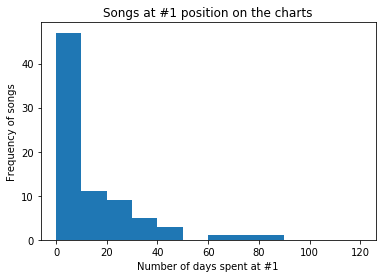

In [12]:
plt.hist(Counter(num_one_songs).values(), bins = np.arange(0,125,10)) # better align our bins
plt.title('Songs at #1 position on the charts')
plt.xlabel('Number of days spent at #1')
plt.ylabel('Frequency of songs')
plt.show()

* We once again see that the number of days a song stays at the number one position on the charts decreases significantly for each increment of ten days. This distribution actually looks a lot like the total count of number one songs for particular artists.


* So, we now model the probability that a number one song leaves the top spot on a particular day -- let's again try using the Geometric model supported on the set {1, 2, 3, ...} with different parameters and maximize the log-likelihood.

The log-likelihoods for each of the Geometric models are listed as follows: [-375.0246195055668, -293.90616614727173, -299.48655782066373, -331.24360412550146, -376.17379834895195, -430.57044738465885, -493.16308897737434].


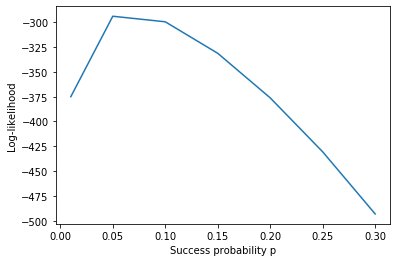

In [13]:
### Geometric model

data = list(Counter(num_one_songs).values())
p_vals = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
n = len(data)

def log_likelihood_geometric(x, n, p):
    ## probability mass function: p(X=k) = p*(1-p)^(k-1)
    x = np.array(x)
    loglik = n*np.log(p) + np.log(1-p)*sum(x-1) # = log(joint pmf)
    return loglik

loglik = []
for p in p_vals:
    loglik.append(log_likelihood_geometric(data, n, p))
    
print('The log-likelihoods for each of the Geometric models are listed as follows: {}.'.format(loglik))

line_graph = plt.plot(p_vals, loglik)
plt.xlabel('Success probability p')
plt.ylabel('Log-likelihood')
plt.show()

* We see that the log-likelihood using the Geometric model is maximized with success probability $p=0.05$. This model suggests that the probability a song loses its number one position on a particular day equals 0.05.

* Since Geometric(0.05) has highest log-likelihood, we choose to model the probability that a number one song leaves the top spot as a draw from a Geometric distribution with success probability $p=0.05$. This model suggests that the probability a song loses its number one position on the charts for any particular day equals 0.05.


* We note that there are a couple of downfalls with using this model, such as the lack of independence between trials (whether or not a song will last another day at number one). There is also a potential issue with a non-constant probability of exiting the number one position. These issues are due to the irregular release of music, such that very popular albums can immediately flood the charts, causing songs to lose their spot at number one, while other periods of time can be without any new music. Additionally, we should note that we are not exactly finding the probability that a song leaves the top spot on the charts on a particular day. Technically, our model is using the total number of days a song spends at the number one position and allowing songs to go in and out of the top spot. Even though this is not technically accurate, it is unlikely that a song leaves the top spot and later returns (barring weird external factors such as artist death).


* Using the model, we conclude that the probability a song loses its number one position on the charts on a particular day equals 0.05. It is also interesting that we had observed the distribution of the number of days a song stays at the number one position to have about the same shape as the distribution of the frequency of number one songs for particular artists, except for a scaling factor of approximately ten, and that both distributions were best modeled using a Geometric distribution with a success parameter a factor of ten apart.


* Now, let's model the probability that a song in the top 200 exits the charts entirely on a particular day:

In [14]:
songs = dat.title
songs_freq_dict = dict(zip(Counter(songs).keys(), Counter(songs).values()))
print('Number of days some songs are in the top 200:', dict(islice(songs_freq_dict.items(), 10)))

Number of days some songs are in the top 200: {'Bad and Boujee (feat. Lil Uzi Vert)': 429, 'Fake Love': 455, 'Starboy': 464, 'Closer': 536, 'Black Beatles': 240, 'Broccoli (feat. Lil Yachty)': 393, 'One Dance': 498, 'Caroline': 389, 'Let Me Love You': 151, 'Bounce Back': 468}


* It makes sense that songs tend to spend significantly more days in the top 200 than at number one position. Let's examine the distribution of the number of days a song stays on the charts:

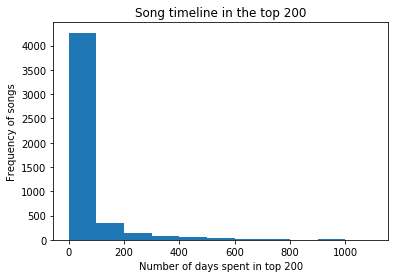

In [15]:
plt.hist(Counter(songs).values(), bins = np.arange(0,1200,100)) # better align our bins
plt.title('Song timeline in the top 200')
plt.xlabel('Number of days spent in top 200')
plt.ylabel('Frequency of songs')
plt.show()

* We see a very steep decrease in the number of days a song stays on the charts followed by a lesser degree of decrease. This suggests that a song is very likely to leave the charts quickly. If a song makes it past a certain amount of time on the charts, it is still likely to exit but less so than before.


* Let's now model the probability that a song in the top 200 exits the charts entirely on a particular day -- we again use the Geometric model (for comparison and since other log-likelihood calculations require us to take factorials, but some of our entries are too high resulting in an overflow error) with different parameters and maximize the log-likelihood.

The log-likelihoods for each of the Geometric models are listed as follows: [-34310.12489479444, -27309.789995523828, -25069.59568432712, -24254.50719226127, -24026.473336149793, -24122.900623675083, -24426.858078482997, -24876.001358448775, -25433.143083535077, -26074.320579374667, -26783.194150142437].


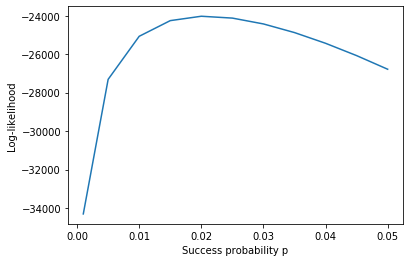

In [16]:
### Geometric model

data = list(Counter(songs).values())
p_vals = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
n = len(data)

def log_likelihood_geometric(x, n, p):
    ## probability mass function: p(X=k) = p*(1-p)^(k-1)
    x = np.array(x)
    loglik = n*np.log(p) + np.log(1-p)*sum(x-1) # = log(joint pmf)
    return loglik

loglik = []
for p in p_vals:
    loglik.append(log_likelihood_geometric(data, n, p))
    
print('The log-likelihoods for each of the Geometric models are listed as follows: {}.'.format(loglik))

line_graph = plt.plot(p_vals, loglik)
plt.xlabel('Success probability p')
plt.ylabel('Log-likelihood')
plt.show()

* We see that the log-likelihood using a Geometric model is maximized with success probability $p=0.02$. This suggests that the probability a song exits the charts on a given day is equal to 0.02.

* We note that many of the downfalls mentioned when using the Geometric model to find the probability that a song exits the top spot on the charts hold in this scenario as well. We have an additional problem here where our success parameter $p$ appears to decrease past a certain number of days spent on the charts, as previously discussed.

* Thus, since the probability of a number one song leaving the top spot on a given day is approximately 0.05 and the probability that a song exits the charts entirely on a particular day is approximately 0.02, we conclude that it is more than twice as likely for a song to leave the top spot than for a song to leave the charts on a given day. This makes sense since there is much more competition for the top spot than there is for the top 200 (plus, there are many more opportunities to be in the top 200 than the number one position).

### Most important words in song titles 

* Next, we look to find the most "important" words in song titles. We break this task up into three parts:

    1. Finding the most frequently used words in song titles
    2. Finding the words which are most commonly used in English language
    3. Removing most common words in song titles which are also most common in English language
    
    
* The remaining words are the most frequently used words in song titles and are not simply prevalent due to being commonly used in English. Thus, we define the remaining words as the most important words in song titles.

__Part 1__: Finding the most frequently used words in song titles

In [17]:
# pre-process song titles
song_titles = np.asarray([x.lower() for x in dat.title.unique()]) # lowercase all song titles
song_titles = np.asarray([re.sub(r'\([^)]*\)', '', x) for x in song_titles]) # get rid of text in parentheses to remove featured artists
print('Some song titles:', song_titles[0:10])

Some song titles: ['bad and boujee ' 'fake love' 'starboy' 'closer' 'black beatles'
 'broccoli ' 'one dance' 'caroline' 'let me love you' 'bounce back']


In [18]:
song_titles_words = [re.findall(r'\b\w+\b',x) for x in song_titles] # extract words from each song
print('Words in some song titles:', song_titles_words[0:10])

Words in some song titles: [['bad', 'and', 'boujee'], ['fake', 'love'], ['starboy'], ['closer'], ['black', 'beatles'], ['broccoli'], ['one', 'dance'], ['caroline'], ['let', 'me', 'love', 'you'], ['bounce', 'back']]


In [19]:
song_titles_words_all = (list(chain.from_iterable(song_titles_words))) # aggregate words in song titles
print('Pooled words from some song titles:', song_titles_words_all[0:10])

Pooled words from some song titles: ['bad', 'and', 'boujee', 'fake', 'love', 'starboy', 'closer', 'black', 'beatles', 'broccoli']


In [20]:
# first ten elements in dictionary of song title words and frequency in song titles
print('Dictionary of some words in song titles and their frequency:',dict(islice(dict(zip(Counter(song_titles_words_all).keys(), Counter(song_titles_words_all).values())).items(), 10)))

Dictionary of some words in song titles and their frequency: {'bad': 38, 'and': 43, 'boujee': 1, 'fake': 4, 'love': 137, 'starboy': 1, 'closer': 4, 'black': 18, 'beatles': 1, 'broccoli': 1}


In [21]:
song_word_dict = dict(zip(Counter(song_titles_words_all).keys(), Counter(song_titles_words_all).values())) # save above dictionary

# sort dictionary by count and append to list
song_word_list = []
[song_word_list.append([w, song_word_dict[w]]) for w in sorted(song_word_dict, key=song_word_dict.get, reverse=True)]

print('Top 25 most frequent words in song titles:', song_word_list[0:25])

Top 25 most frequent words in song titles: [['the', 382], ['me', 244], ['i', 243], ['you', 237], ['it', 156], ['love', 137], ['a', 128], ['my', 122], ['t', 121], ['to', 117], ['in', 113], ['on', 109], ['up', 100], ['of', 92], ['s', 92], ['remix', 81], ['no', 69], ['for', 69], ['don', 65], ['christmas', 62], ['out', 58], ['like', 54], ['from', 50], ['what', 50], ['all', 50]]


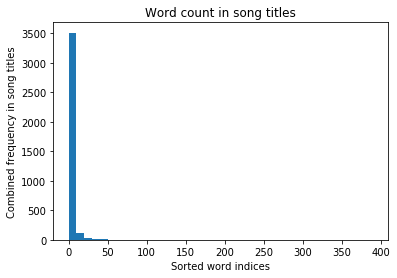

In [22]:
song_word_freq = np.asarray([value for word, value in song_word_list]) # extract counts of each word in song titles

# plot histogram of unique word counts in song titles
plt.hist(song_word_freq, bins = np.arange(0,400,10)) # show sharp decrease in word usage past most common words
plt.title('Word count in song titles')
plt.xlabel('Sorted word indices')
plt.ylabel('Combined frequency in song titles')
plt.show()

* We observe that, other than the most common words, most words in song titles are not at all prevalent. We want to find the words that are most frequently used in song titles, but we want these words to not just be the commonly used words in English -- we want to find what makes these song titles important by finding their prominent, __unique__ words.

__Part 2__: Finding the words which are most commonly used in English language

In [23]:
url = 'https://www.rypeapp.com/most-common-english-words/' # webpage listing 100 most common words in English language
response = requests.get(url)

In [24]:
response # successful!

<Response [200]>

In [25]:
soup = BeautifulSoup(response.text, 'html.parser') # use BeautifulSoup library

In [26]:
soup.findAll('td')[0:5] # first five words on webpage (note: the words do not appear in the correct order of frequency)

[<td nowrap="nowrap" valign="bottom" width="90">1. the</td>,
 <td nowrap="nowrap" valign="bottom" width="90">21. at</td>,
 <td nowrap="nowrap" valign="bottom" width="90">41. there</td>,
 <td nowrap="nowrap" valign="bottom" width="100">61. some</td>,
 <td nowrap="nowrap" valign="bottom" width="90">81. my</td>]

In [27]:
english_word_rank_list = []
english_word_list = []

for text in soup.findAll('td'):
    english_word_rank_list.append(re.findall(r'[0-9]+', text.get_text())) # extract numbers => rank of words
    english_word_list.append(re.findall(r'[a-zA-Z]+', text.get_text())) # extract words
    
print('Some of the most frequently used words in English language:', english_word_list[0:5])
print('Corresponding rank of usage frequency:', english_word_rank_list[0:5])

Some of the most frequently used words in English language: [['the'], ['at'], ['there'], ['some'], ['my']]
Corresponding rank of usage frequency: [['1'], ['21'], ['41'], ['61'], ['81']]


In [28]:
# unlist individual elements
english_word_rank_list = (list(chain.from_iterable(english_word_rank_list)))
english_word_list = (list(chain.from_iterable(english_word_list)))

In [29]:
english_words_dict = dict(zip(np.asarray(english_word_rank_list).astype(int), english_word_list)) # concatenate lists into dictionary
print('Dictionary of some frequently used words in English language and their rank:',dict(islice(english_words_dict.items(), 10)))

Dictionary of some frequently used words in English language and their rank: {1: 'the', 21: 'at', 41: 'there', 61: 'some', 81: 'my', 2: 'of', 22: 'be', 42: 'use', 62: 'her', 82: 'than'}


In [30]:
# sort by rank of how common each word is and append to list
english_words_list = []
[english_words_list.append([w, english_words_dict[w]]) for w in sorted(english_words_dict)]
print('First four elements in list of most frequently used words in English language:', english_words_list[0:4])

First four elements in list of most frequently used words in English language: [[1, 'the'], [2, 'of'], [3, 'and'], [4, 'a']]


__Part 3__: Removing most common words in song titles which are also most common in English language

In [31]:
most_words_songs = np.asarray([word for word,count in song_word_list]) # list of most common words in song titles
most_words_english = np.char.lower(np.asarray([word for count,word in english_words_list])) # list of most common words in English language

print('Top 10 words in song titles:',most_words_songs[0:10])
print('Top 10 words in English language:',most_words_english[0:10])

Top 10 words in song titles: ['the' 'me' 'i' 'you' 'it' 'love' 'a' 'my' 't' 'to']
Top 10 words in English language: ['the' 'of' 'and' 'a' 'to' 'in' 'is' 'you' 'that' 'it']


In [32]:
# top 43 words in song titles NOT in most commmon English words
song_words = [word for word in most_words_songs[~np.in1d(most_words_songs, most_words_english)]][0:43] 
song_words

['me',
 'love',
 't',
 's',
 'remix',
 'don',
 'christmas',
 'good',
 'm',
 'bad',
 'back',
 'let',
 'off',
 'life',
 'know',
 '2',
 'u',
 'feat',
 'big',
 'girl',
 'feel',
 'never',
 'la',
 'night',
 'version',
 'new',
 'too',
 'god',
 'man',
 'home',
 'right',
 'money',
 'heart',
 'high',
 'remastered',
 'talk',
 'better',
 'say',
 'want',
 'summer',
 'baby',
 'boy',
 'black']

In [33]:
# extract top 35 words in song titles NOT in most commmon English words
### IMPORTANT NOTE: we remove words that were part of contractions (e.g. 't', 'don'), slang (e.g., 'u'), numbers (e.g., '2'), 
### other languages (e.g., 'la'), and 'feat' (we do not want to take feat, or featuring artists into account)

want_to_remove = ['t','s','don','m','2','u','feat','la']
idxs_real_words = [i for i, x in enumerate(song_words) if x not in want_to_remove]

# get words in most_words_songs that are not in our want_to_remove list
song_words = [word for word in np.take([word for word in most_words_songs[~np.in1d(most_words_songs, most_words_english)]], idxs_real_words)]

In [34]:
print('Top 35 most important words in song titles:\n\n',song_words)

Top 35 most important words in song titles:

 ['me', 'love', 'remix', 'christmas', 'good', 'bad', 'back', 'let', 'off', 'life', 'know', 'big', 'girl', 'feel', 'never', 'night', 'version', 'new', 'too', 'god', 'man', 'home', 'right', 'money', 'heart', 'high', 'remastered', 'talk', 'better', 'say', 'want', 'summer', 'baby', 'boy', 'black']


###### Notable words:
* __infatuated__ -- love, heart, girl, baby, feel (note: I manually went through song titles and saw that 'man' and 'boy' usually were not infatuated-type songs)
* __seasonal__ -- christmas, summer
* __musical__ -- remix, remastered, version
* __profound__ -- life, god
* __enjoyment__ -- night, money

* We found that, after processing words that are very common, many words used in song titles are very thematic. That is, they tend to fall into a few notable categories which help us classify the songs.


* Some of these words suggest infatuation, perhaps indicating a love song, while others are associated with seasonal songs and enjoyment/party songs. Interestingly, there is a whole category dedicated to rather profound concepts, such as life and god. Another category has words with musical concepts, such as 'version' and 'remix'.

### Song categories and their muscial attributes

* Now, let's examine the categories of songs we defined using their titles and see if they have any notable musical attributes. We do this by fitting simple linear regression models between songs in a particular catergory and examining the slopes associated with each audio feature:

In [35]:
unique_songs_dat = dat.drop_duplicates(['title']) # dataframe where each song appears only once

In [36]:
# lowercase all song titles
pd.options.mode.chained_assignment = None # ignore chained assignment warnings
unique_songs_dat_copy = unique_songs_dat.copy()
unique_songs_dat_copy.title = unique_songs_dat_copy.title.str.lower() # lowercase all song titles
unique_songs_dat.loc[:,'title'] = unique_songs_dat_copy['title']
print(unique_songs_dat.title.head())

0    bad and boujee (feat. lil uzi vert)
1                              fake love
2                                starboy
3                                 closer
4                          black beatles
Name: title, dtype: object


In [37]:
song_titles_words = [re.findall(r'\b\w+\b',x) for x in unique_songs_dat.title] # extract words from each song
print('Individual words from first five songs:', song_titles_words[0:5])

Individual words from first five songs: [['bad', 'and', 'boujee', 'feat', 'lil', 'uzi', 'vert'], ['fake', 'love'], ['starboy'], ['closer'], ['black', 'beatles']]


* __Note__: we hypothesize that songs related to Christmas and songs related to summer will have very different musical attributes. This is because Christmas songs tend to be slower and calmer while summer songs tend towards being upbeat and exciting. Thus, we break up the seasonal song category into two separate groups.

In [38]:
# from previous findings
infatuated_words = ['love', 'heart', 'girl', 'baby', 'feel']
christmas_words = ['christmas']
summer_words = ['summer']
musical_words = ['remix', 'remastered', 'version']
profound_words = ['life', 'god']
enjoyment_words = ['night', 'money']

In [39]:
infatuated_songs_list = []
christmas_songs_list = []
summer_songs_list = []
musical_songs_list = []
profound_songs_list = []
enjoyment_songs_list = []

# for each song, append 'True' to song category list if the song title contains an important word in that category; append 'False' otherwise
for song_ix in range(len(unique_songs_dat.title)):
    infatuated_songs_list.append(any(song_titles_words[song_ix][x] in infatuated_words for x in range(len(song_titles_words[song_ix]))))
    christmas_songs_list.append(any(song_titles_words[song_ix][x] in christmas_words for x in range(len(song_titles_words[song_ix]))))
    summer_songs_list.append(any(song_titles_words[song_ix][x] in summer_words for x in range(len(song_titles_words[song_ix]))))
    musical_songs_list.append(any(song_titles_words[song_ix][x] in musical_words for x in range(len(song_titles_words[song_ix]))))
    profound_songs_list.append(any(song_titles_words[song_ix][x] in profound_words for x in range(len(song_titles_words[song_ix]))))
    enjoyment_songs_list.append(any(song_titles_words[song_ix][x] in enjoyment_words for x in range(len(song_titles_words[song_ix]))))

In [40]:
# convert 'T/F' to numeric 0/1
infatuated_ixs = np.asarray(infatuated_songs_list).astype(int)
christmas_ixs = np.asarray(christmas_songs_list).astype(int)
summer_ixs = np.asarray(summer_songs_list).astype(int)
musical_ixs = np.asarray(musical_songs_list).astype(int)
profound_ixs = np.asarray(profound_songs_list).astype(int)
enjoyment_ixs = np.asarray(enjoyment_songs_list).astype(int)

In [41]:
total_num_songs = len(unique_songs_dat.title) # total number of songs

print('Infatuated song percentage:', 100*sum(infatuated_ixs)/total_num_songs)
print('Christmas song percentage:', 100*sum(christmas_ixs)/total_num_songs)
print('Summer song percentage:', 100*sum(summer_ixs)/total_num_songs)
print('Musical song percentage:', 100*sum(musical_ixs)/total_num_songs)
print('Profound song percentage:', 100*sum(profound_ixs)/total_num_songs)
print('Enjoyment song percentage:', 100*sum(enjoyment_ixs)/total_num_songs)

Infatuated song percentage: 5.371984593553618
Christmas song percentage: 1.3379282383944862
Summer song percentage: 0.3851611595378066
Musical song percentage: 2.71639975674032
Profound song percentage: 1.1554834786134198
Enjoyment song percentage: 0.9730387188323535


* Clearly, our grouping songs into categories by the presence of our defined "important" words in song tiles does an okay, but not very realistic job of grouping the song types. For example, we expect more than 5% of songs to be love songs and more than 1% of songs to be enjoyment/party type songs. We continue our analysis with this note in mind.


* We should also be careful when drawing conclusions about a category of songs which makes up very little of our total data. Arbitrarily, we will define 1% of the data as a cutoff, so we will be cognizant when drawing conclusions about summer songs.

In [42]:
# append our lists to the unique_songs_dat dataframe 
unique_songs_dat['infatuated'] = infatuated_ixs
unique_songs_dat['christmas'] = christmas_ixs
unique_songs_dat['summer'] = summer_ixs
unique_songs_dat['musical'] = musical_ixs
unique_songs_dat['profound'] = profound_ixs
unique_songs_dat['enjoyment'] = enjoyment_ixs

In [43]:
unique_songs_dat.head() # observe new features based on song classification

,rank,date,artist,title,streams,danceability,energy,key,loudness,mode,...,tempo,uri,duration_ms,time_signature,infatuated,christmas,summer,musical,profound,enjoyment
0,1,2017-01-01,Migos,bad and boujee (feat. lil uzi vert),1371493,0.927,0.665,11.0,-5.313,1.0,...,127.076,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,343150.0,4.0,0,0,0,0,0,0
1,2,2017-01-01,Drake,fake love,1180074,0.928,0.481,9.0,-9.350,0.0,...,134.007,spotify:track:343YBumqHu19cGoGARUTsd,210937.0,4.0,1,0,0,0,0,0
2,3,2017-01-01,The Weeknd,starboy,1064351,0.679,0.587,7.0,-7.015,1.0,...,186.003,spotify:track:7MXVkk9YMctZqd1Srtv4MB,230453.0,4.0,0,0,0,0,0,0
3,4,2017-01-01,The Chainsmokers,closer,1010492,0.748,0.524,8.0,-5.599,1.0,...,95.010,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,244960.0,4.0,0,0,0,0,0,0
4,5,2017-01-01,Rae Sremmurd,black beatles,874289,0.794,0.632,0.0,-6.163,1.0,...,145.926,spotify:track:6fujklziTHa8uoM5OQSfIo,291893.0,4.0,0,0,0,0,0,0


In [44]:
# we observed some NaNs in the data, so we remove all rows(songs) with NaNs to do analysis
clean_data = unique_songs_dat[unique_songs_dat.key.notna()]
print('Number of rows(songs) removed:', len(unique_songs_dat.artist) - len(clean_data.artist))

Number of rows(songs) removed: 105


In [45]:
musical_features = list(clean_data.iloc[:, 5:19]) # names of musical features
del musical_features[11] # get rid of 'song_uri' as a musical feature

for song_type in list(['infatuated', 'christmas', 'summer', 'musical', 'profound', 'enjoyment']):
    print('\n\nSong type:\n', song_type.upper())
    for feature in musical_features:
        model = LinearRegression().fit(clean_data[[song_type]], clean_data[[feature]]) # simple linear regression of musical feature on song type
        print('\nFeature:', feature)
        print('Slope:', *model.coef_[0]) # associated slope of regression



Song type:
 INFATUATED

Feature: danceability
Slope: -0.016253158642173245

Feature: energy
Slope: 0.0009713710285316907

Feature: key
Slope: 0.281324676514562

Feature: loudness
Slope: -0.012348672949662555

Feature: mode
Slope: -0.004434467909661248

Feature: speechiness
Slope: -0.012400192238015301

Feature: acousticness
Slope: 0.01688165277753946

Feature: instrumentalness
Slope: -0.0040639379215055855

Feature: liveness
Slope: -0.004254701876985995

Feature: valence
Slope: 0.01022022663762549

Feature: tempo
Slope: -0.12323252304065835

Feature: duration_ms
Slope: -4649.827894502309

Feature: time_signature
Slope: -0.0016591773245765316


Song type:
 CHRISTMAS

Feature: danceability
Slope: -0.16308222925790733

Feature: energy
Slope: -0.17494838773731688

Feature: key
Slope: -0.16088796714065604

Feature: loudness
Slope: -3.357610626335287

Feature: mode
Slope: 0.22992715492357035

Feature: speechiness
Slope: -0.09962194103998233

Feature: acousticness
Slope: 0.3381712919339071


In [46]:
clean_data[musical_features].describe().iloc[[2]] # get standard deviation of each musical feature for a standard of comparison

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
std,0.151638,0.172021,3.684613,2.691636,0.490482,0.132605,0.24606,0.08523,0.1393,0.218618,29.535939,55967.440219,0.337426


* Using standard deviation of each musical feature as a standard of comparison, we determine that danceability and energy are more than one standard deviation lower for Christmas songs as compared to non-Christmas songs. Thus, we can say that Christmas songs are much more quaint and peaceful than other songs. Likewise, we determine that loudness is well over one standard deviation lower for Christmas songs as compared to non-Christmas songs. This substantiates our previous argument that Christmas songs tend to be quiter and more peaceful. Acousticness is also well over one standard deviation higher for Christmas songs compared to other songs. According to Wikipedia, accoustic songs produce sound through acoustic means, as opposed to electric or electronic means, which makes sense because Christmas songs tend to sound more natural and man-made as opposed to produced. Additionally, the time signature for Christmas songs is also almost one standard deviation lower than non-Christmas songs. While most songs tend to be set in 4/4 time, many Christmas songs are made in 3/4 time, such as 'Christmastime is Here', 'We Wish You a Merry Christmas', and 'Silver Bells' (according to http://www.musicalmama.com/blogposts/2018/11/28/christmas-songs-in-34-time), which lowers the average time signature of Christmas songs.


* We also make some observations by "eye-ing" notable differences (less significant than those found using standard deviation as method of comparison). We see that tempo tends to be lower for Christmas songs, which is sensible given its peaceful nature. Interestingly, Christmas songs also tend to be a bit shorter than other types of songs. In addition, we observe that tempo tends to be slightly higher for summer and enjoyment songs. These songs usually take on an upbeat character, so I am not surprised that they tend to be a bit more quickly paced according to their tempo.


* While using the important words in song titles was by no means a comprehensive method to cluster the songs based on their musical features, it does give us some valuable insight into the different song types and their characters. In particular, we can see just how distinct Christmas music is as a genre.

# Streams

### Spotify usage (as measured by total weekly streams) over time (2017-present)

In [47]:
# total streams for each day appended to list 'strms'
strms = [sum(dat.streams[dat.date == date]) for date in dat.date.unique()]
print('Total streams for first few days:', strms[0:7])

Total streams for first few days: [55139058, 48894824, 55168814, 55939894, 56235124, 59503480, 54059621]


In [48]:
# total streams for each week appended to list 'tot_weekly_streams'
tot_weekly_streams = np.add.reduceat(np.asarray(strms), np.arange(0, len(strms), 7))
tot_weekly_streams = tot_weekly_streams[:-1] # remove last entry bc not a full week of data
print('Total streams for first few weeks:', tot_weekly_streams[0:7]) # note that sum(strms[0:7]) = tot_weekly_streams[0]

Total streams for first few weeks: [384940815 410773282 418037694 424685581 446362951 446611950 459244530]


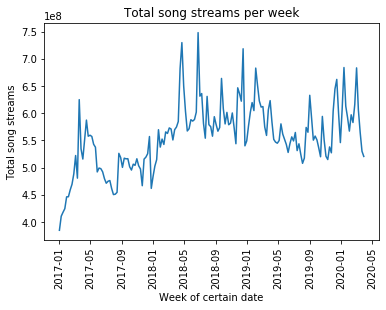

In [55]:
each_date = pd.to_datetime(dat.date.unique()) # convert each date to 'datetime' object
dates = [each_date[0]+datetime.timedelta(7*wk) for wk in range(len(tot_weekly_streams))] # store first day of each week

plt.plot(dates,tot_weekly_streams)
plt.title('Total song streams per week')
plt.xlabel('Week of certain date')
plt.ylabel('Total song streams')
plt.xticks(rotation=90)
plt.show()

In [50]:
# fit linear regression model between date (first day of each week) and total number of streams during the week
streams_model = LinearRegression().fit(pd.DataFrame(pd.to_datetime(np.asarray(dates)).map(datetime.datetime.toordinal)), tot_weekly_streams)
print('𝑟-squared:', streams_model.score(pd.DataFrame(pd.to_datetime(np.asarray(dates)).map(datetime.datetime.toordinal)), tot_weekly_streams))

𝑟-squared: 0.251937642059627


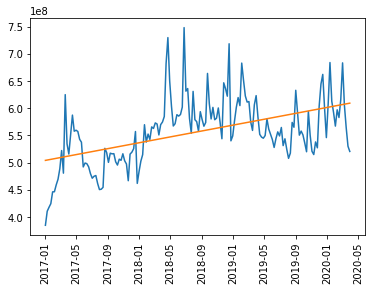

In [51]:
m = streams_model.coef_[0] # slope from regression model
b = streams_model.intercept_ # intercept from regression model
plt.plot(dates,tot_weekly_streams)

# add line of best fit from regression model to plot of total song streams per week
plt.plot(pd.to_datetime(np.asarray(dates)).map(datetime.datetime.toordinal), m*pd.to_datetime(np.asarray(dates)).map(datetime.datetime.toordinal) + b)
plt.xticks(rotation=90)
plt.show()

In [52]:
print('Slope -- Expected increase in total number of streams per week:', m)

Slope -- Expected increase in total number of streams per week: 88863.13070825336


* While it makes sense for the slope to suggest a modest increase in the total number of streams per week on the platform, we must note the poor linear relationship between the date and total number of weekly streams on Spotify (as determined by $r^2$ value and seen in our plot above). Unfortunately, there does not even appear to be a constant seasonal effect for which we can account in our model. One reason I hypothesize that linear regression does not work well in this scenario is due to the lack of independence between observations; that is, the lack of independence between number of streams by week. This is largely due, I believe, to the seemingly random pattern by which music is released. When new music is released, many people are motivated to stream it on Spotify, thereby increasing the number of weekly streams on the platform. On the other hand, many users get bored of hearing the same songs on repeat, and are less inclined to stream music on the platform when no new music is released. Since this release timing is seemingly random (I am surprised not to see a "song of the summer" type effect; nevertheless, I digress), there are random surges of streaming and equally random periods of decreased listening on the platform.

### Predicting max streams

In [53]:
# examine correlation between numeric features
dat.select_dtypes(exclude=['object']).corr()

,rank,streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
rank,1.000000,-0.724975,-0.083407,0.025537,0.018969,-0.015841,0.035518,-0.021400,0.020887,-0.012169,-0.007103,-0.002531,-0.006837,0.019675,-0.008730
streams,-0.724975,1.000000,0.075135,-0.028150,-0.009408,0.009745,-0.025449,0.019268,-0.017938,0.009392,0.039713,0.013407,0.006813,-0.026280,0.012693
danceability,-0.083407,0.075135,1.000000,-0.009159,-0.023191,0.073905,-0.083410,0.280305,-0.280773,-0.044703,-0.050056,0.228950,0.015487,-0.123850,0.100677
energy,0.025537,-0.028150,-0.009159,1.000000,0.015939,0.728078,0.007087,-0.061341,-0.455068,-0.091591,0.075383,0.359844,0.143536,0.036688,0.092241
key,0.018969,-0.009408,-0.023191,0.015939,1.000000,0.029376,-0.144063,-0.005674,0.015732,-0.019991,-0.034291,0.069289,-0.072700,-0.030794,-0.002441
loudness,-0.015841,0.009745,0.073905,0.728078,0.029376,1.000000,0.027741,-0.154172,-0.388458,-0.156116,0.013196,0.257109,0.094299,0.008850,0.091820
mode,0.035518,-0.025449,-0.083410,0.007087,-0.144063,0.027741,1.000000,-0.126489,0.007109,-0.025402,-0.003444,-0.010918,0.006295,0.038710,-0.015234
speechiness,-0.021400,0.019268,0.280305,-0.061341,-0.005674,-0.154172,-0.126489,1.000000,-0.133823,-0.035806,0.030043,0.015740,0.169778,-0.042255,0.066087
acousticness,0.020887,-0.017938,-0.280773,-0.455068,0.015732,-0.388458,0.007109,-0.133823,1.000000,0.106222,-0.072689,-0.062124,-0.159566,-0.038253,-0.076771
instrumentalness,-0.012169,0.009392,-0.044703,-0.091591,-0.019991,-0.156116,-0.025402,-0.035806,0.106222,1.000000,-0.009295,-0.101930,0.016459,0.038858,-0.040044


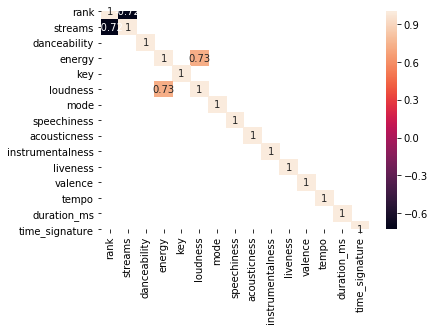

In [54]:
# let's see which numeric features are strongly correlated
sn.heatmap(dat.select_dtypes(exclude=['object']).corr()[abs(dat.select_dtypes(exclude=['object']).corr()) > 0.5], annot=True)
plt.show()